<a href="https://colab.research.google.com/github/rkme/memalloy/blob/main/LSTM_memalloy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MemAlloy: Learning shape-memory alloy dynamics with Long Short-Term memory models.

### < Project summary >

First we can import the relevant data and libraries. Our test data is stored on the [GitHub repository](https://github.com/rkme/memalloy.git), which also contains our fully-trained models.


In [1]:
!git clone https://github.com/rkme/memalloy.git

Cloning into 'memalloy'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 75 (delta 19), reused 63 (delta 12), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [15]:
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler # Need this to scale inputs 
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.activations import relu
from tensorflow.keras.optimizers import Adam
from memalloy import helper_funcs as hf
import matplotlib.pyplot as plt
%matplotlib inline

Then we can load in our data files for each test case: unidirectional and bidirectional bending.

In [10]:
# Unidirectional data file
uni_train_path = "memalloy/data/CCW/cv_datalogger_2021-9-1_170650.txt"
# Bidirectional data file
bi_train_path = "memalloy/data/bidirectional/cv_datalogger_2021-9-2_144837.txt"

uni_train_data = hf.load_file(uni_train_path)
bi_train_data = hf.load_file(bi_train_path)

Reading file at path memalloy/data/CCW/cv_datalogger_2021-9-1_170650.txt ...
Read complete!
Reading file at path memalloy/data/bidirectional/cv_datalogger_2021-9-2_144837.txt ...
Read complete!


In [26]:
# These are the different data labels
bi_train_data.head()

,Timestamp (millisec since midnight today),Test time,theta_targ,pwm_0,pwm_1,x_251,y_251,x_285,y_285,theta,Tl,Tr,Vl,Vr,Al,Ar,Bl,Br,T_time,B_time,pctime
0,53321684,0.000,0.0,0.0,0.0000,307.777678,361.598276,302.884417,73.040714,0.000000,27.75,28.25,0.015113,0.0,-7.706694e-08,-3.891736,0.062500,0.0,7881836,7801239,2021-9-2 14:48:41.684388
1,53321783,0.000,0.0,0.0,0.0000,307.764919,361.577777,302.930488,73.105172,-0.011395,27.75,28.25,0.015113,0.0,1.612826e-03,-3.892562,0.031250,0.0,7983216,7941346,2021-9-2 14:48:41.783387
2,53321883,0.099,0.0,0.0,0.0007,307.794110,361.621848,302.931542,73.169177,-0.005742,27.75,28.25,0.015113,0.0,3.225729e-03,-3.891736,0.000000,0.0,8083466,8051545,2021-9-2 14:48:41.883460
3,53321984,0.199,0.0,0.0,0.0003,307.747284,361.601300,302.941144,73.133831,-0.016996,27.75,28.25,0.015113,0.0,6.048379e-02,-3.864463,0.015625,0.0,8102082,8091553,2021-9-2 14:48:41.984468
4,53322084,0.301,0.0,0.0,0.0010,307.689039,361.569020,302.930877,73.114522,-0.026480,27.75,28.25,0.015113,0.0,6.129025e-02,-3.862810,0.062500,0.0,8282227,8231629,2021-9-2 14:48:42.084448


In [13]:
# Example of building time-lag dataset
#Get relevant arrays
sec = uni_train_data.iloc[:,1] # time corrected column [seconds]
pwm = uni_train_data.iloc[:,4] # PWM duty cycle [%]
ang = uni_train_data.iloc[:, 16].astype(float) # angle of bend
temp = uni_train_data.iloc[:,10] # Temperature of wire [deg C]

raw = pd.DataFrame()
raw['ob1'] = [x for x in temp[0:10]]
raw['ob2'] = [x for x in pwm[0:10]]
test_values = raw.values
test_data = hf.series_to_supervised(test_values, n_in=4, n_out=2)
print(test_data)
# Notice that it skips the first n_in elements in order to line everything up

   var1(t-4)  var2(t-4)  var1(t-3)  ...  var2(t)  var1(t+1)  var2(t+1)
4      26.00     0.0000      26.25  ...   0.0016      26.00     0.0014
5      26.25     0.0000      26.25  ...   0.0014      26.00     0.0015
6      26.25     0.0000      26.00  ...   0.0015      26.25     0.0004
7      26.00     0.0014      26.00  ...   0.0004      26.00     0.0011
8      26.00     0.0016      26.00  ...   0.0011      26.00     0.0012

[5 rows x 12 columns]


Once we have our datasets ready to be fed into this supervised learning problem, we can define our model architecture. We train on the first 67% of our data and validate on the last 33%.

In [34]:
def train_model(dataset, epochs = 20, verbose = 1):
  [train_X, train_y, test_X, test_y] = hf.gen_train_test(dataset.values)

  # design network
  model = Sequential()
  model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(300, activation = relu))
  model.add(Dense(1, activation = relu))
  optimizer = Adam(learning_rate=0.01, decay = 0.9)
  model.compile(loss='mse', optimizer=optimizer)
  # fit network
  history = model.fit(train_X, train_y, epochs=epochs, batch_size=100, \
                      validation_data=(test_X, test_y), verbose=verbose, shuffle=False)
  #plotting history
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

  return (model, history)

Using this trained model we can predict one step ahead as below:

In [37]:
def one_step_predict(dataset, model):
  [train_X, train_y, test_X, test_y] = hf.gen_train_test(dataset.values)
  yhat = model.predict(test_X)
  test_X2D = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  # invert scaling for forecast
  inv_yhat = np.concatenate((yhat, test_X2D[:, 1:]), axis=1)
  # inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_X2D[:, 1:]), axis=1)
  # inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]
  # calculate MSE
  mse = mean_squared_error(inv_y, inv_yhat)
  print('Test MSE: %.6f' % mse)
  return inv_y, inv_yhat

We can also attempt to predict an open-loop rollout using just a single point as our reference by calling model.predict() on the models own predictions.

In [19]:
def create_rollout_dataset(model, X_data, start = 500, window = 200):
  test_X2D = X_data.reshape((X_data.shape[0], X_data.shape[2]))

  base = test_X2D[start-1:start] # first observation 
  vars = base.shape[1]
  for i in range(start, start+window):
    # Predict based on all previous steps, then take most recent prediction
    pred = model.predict(base[-1].reshape(1,1,vars))
    # Concatenate it to the end as a new [t-1], alongside real var1, var2 vals
    # Replaces 2nd column (measured bending[t-1])
    newRow = np.concatenate((test_X2D[i, 0:vars//2], pred[0], 
                             test_X2D[i,vars//2+1:]), axis = 0)
    base = np.concatenate((base, newRow.reshape((1,vars))), axis = 0)
  return base[1:] #ignore the first observed row

Now that our model is demonstrated, we can demonstrate training the model, making one-step predictions, and making rollout predictions. We will use Bidirectional PWM as our example for this (Test 3 in the paper).

Reading file at path memalloy/data/bidirectional/cv_datalogger_2021-9-2_144837.txt ...
Read complete!
   var1(t-1)  var2(t-1)  var3(t-1)  var1(t)   var2(t)   var3(t)
1        0.0   0.000000   0.472640      0.0  0.000000  0.472244
2        0.0   0.000000   0.472244      0.0  0.001059  0.471849
3        0.0   0.001059   0.471849      0.0  0.000454  0.472047
4        0.0   0.000454   0.472047      0.0  0.001513  0.472640
5        0.0   0.001513   0.472640      0.0  0.002421  0.472640
Epoch 1/20
169/169 [==============================] - 5s 18ms/step - loss: 0.0097 - val_loss: 0.0054
Epoch 2/20
169/169 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 3/20
169/169 [==============================] - 3s 16ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/20
169/169 [==============================] - 3s 16ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/20
169/169 [==============================] - 3s 16ms/step - loss: 8.6848e-04 - val_loss: 8.3965e-04
E

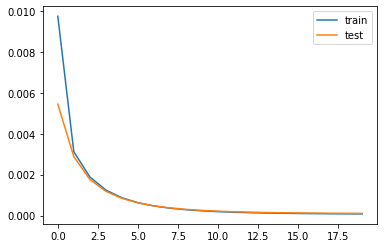

Test MSE: 0.000104


In [39]:
#Test 3
reframed3 = hf.frame_dataset(bi_train_path, mode=3)
(model3, history3) = train_model(reframed3)

In [69]:
# Predicting one-step ahead
y3, y_pred3 = one_step_predict(reframed3, model3)

# Predicting rollout over a window:

[train_X, train_y, test_X, test_y] = hf.gen_train_test(reframed3.values)
left = 150
win = 6000 # these units are timesteps (0.1s), not seconds
right = left + window
rollout3 = create_rollout_dataset(model3, test_X, start = left, window = win)
rollout3y = rollout3[:,rollout3.shape[1]//2] # Predictions in middle col

Test MSE: 0.000104


In [53]:
# Need to hack some reverse scaling based on our data bounds:
uni_angs = uni_train_data.iloc[:, 16].astype(float) # angle of bend
uni_max = np.amax(uni_angs)
#uni_min = 0, unused.

bi_angs = bi_train_data.iloc[:, 16].astype(float) # angle of bend
bi_max = np.amax(bi_angs)
bi_min = np.amin(bi_angs)

Then we can plot the results below:

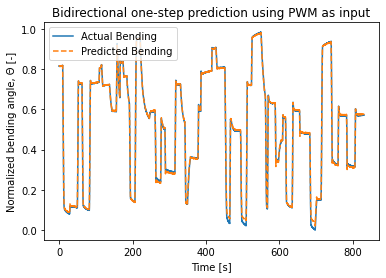

In [54]:
test_t = sec[-len(y3):]-sec.values[-len(y3)]
plt.plot(test_t, y3)
plt.plot(test_t, y_pred3, '--')
# plt.plot(test_X[:, 4], '-.')
# plt.axis([1690,1785, 0, 1.1])
plt.legend(['Actual Bending', 'Predicted Bending', 'Linearly scaled temperature'])
plt.xlabel('Time [s]')
plt.ylabel('Normalized bending angle, Θ [-]')
plt.title("Bidirectional one-step prediction using PWM as input")
plt.show()

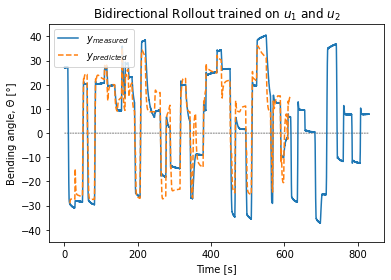

In [70]:
plt.plot(test_t, np.zeros(len(test_t)), 'k--', label = "_nolegend_", \
         linewidth = 0.5) # Center
plt.plot(test_t, test_y*(bi_max-bi_min)+bi_min)
plt.plot(test_t[left:right], rollout3y*(bi_max-bi_min)+bi_min, '--')
# plt.plot(test_t[left:left+1], rollouty[0], 'ro') # highlights start point
plt.legend([r'$y_{measured}$', r'$y_{predicted}$'], loc=2)
plt.xlabel('Time [s]')
plt.ylabel('Bending angle, Θ [°]')
plt.ylim([-45,45])
plt.title(r'Bidirectional Rollout trained on $u_1$ and $u_2$')
plt.show()

The models used in the paper for each mode have been trained and saved in models/. Additionally, the generated rollout data for each model has also been saved in rollouts/. As such, each can be loaded and plotted as below:

In [75]:
model1 = keras.models.load_model("memalloy/models/model1.h5")
reframed1 = hf.frame_dataset(uni_train_path, mode=1)
y1, ypred1 = one_step_predict(reframed1, model1)

rollout1y = np.genfromtxt("memalloy/rollouts/rolloutlong1.out")

Reading file at path memalloy/data/CCW/cv_datalogger_2021-9-1_170650.txt ...
Read complete!
   var1(t-1)  var2(t-1)   var1(t)   var2(t)
1   0.000000   0.002943  0.000000  0.001261
2   0.000000   0.001261  0.000000  0.004414
3   0.000000   0.004414  0.002333  0.000841
4   0.002333   0.000841  0.002667  0.004414
5   0.002667   0.004414  0.002333  0.001261
Test MSE: 0.000029


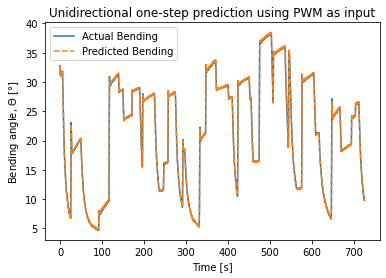

In [74]:
test_t = sec[-len(y1):]-sec.values[-len(y1)]
plt.plot(test_t, y1*uni_max)
plt.plot(test_t, ypred1*uni_max, '--')
plt.legend(['Actual Bending', 'Predicted Bending'])
plt.xlabel('Time [s]')
plt.ylabel(r'Bending angle, Θ [$\degree$]')
plt.title("Unidirectional one-step prediction using PWM as input")
plt.show()

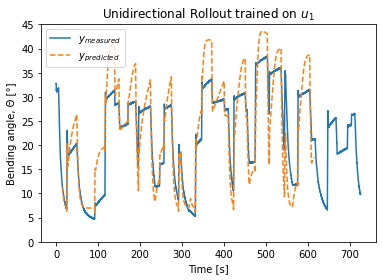

In [78]:
plt.plot(test_t, y1*uni_max)
plt.plot(test_t[left:right], rollout1y*uni_max, '--')
plt.legend([r'$y_{measured}$', r'$y_{predicted}$'], loc=2)
plt.xlabel('Time [s]')
plt.ylabel('Bending angle, Θ [°]')
plt.ylim([0,45])
plt.title(r'Unidirectional Rollout trained on $u_1$')
plt.show()